In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
import penzai
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [3]:
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained("models/gemma-2b-it.gguf", from_type="gemma", load_eager=True)

In [4]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("alpindale/gemma-2b")
tokenizer.padding_side = "right"

In [5]:
import json
save_path = "data/gemma-2b-explanations.json"
if os.path.exists(save_path):
    with open(save_path, "r") as f:
        index_explanations = {int(k): v for k, v in json.load(f).items()}

In [6]:
# from tqdm.auto import trange
# import requests
# max_neurons = 10_000
# try:
#     index_explanations
# except NameError:
#     index_explanations = {}
# step = 25
# for offset in trange(0, max_neurons, step):
#     if all(i in index_explanations for i in range(offset, offset + step)):
#         continue
#     gemma_neurons = requests.post("https://www.neuronpedia.org/api/neurons-offset", json={"modelId": "gemma-2b", "layer": "6-res-jb", "offset": offset}).json()
#     for n in gemma_neurons:
#         for e in n["explanations"]:
#             index_explanations[int(n["index"])] = e["description"]

In [7]:
if not os.path.exists(save_path):
    with open(save_path, "w") as f:
        json.dump(index_explanations, f)
else:
    existing = {int(k): v for k, v in json.load(open(save_path)).items()}
    existing.update(index_explanations)
    with open(save_path, "w") as f:
        json.dump(existing, f)

In [8]:
!mkdir -p models/sae
!wget -c 'https://huggingface.co/jbloom/Gemma-2b-Residual-Stream-SAEs/resolve/main/gemma_2b_blocks.6.hook_resid_post_16384_anthropic_fast_lr/sae_weights.safetensors?download=true' -O 'models/sae/gemma-jb-6.safetensors'
from safetensors import safe_open
with safe_open("models/sae/gemma-jb-6.safetensors", framework="numpy") as st:
    w_dec = st.get_tensor("W_dec")

/usr/local/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-06-27 16:29:43--  https://huggingface.co/jbloom/Gemma-2b-Residual-Stream-SAEs/resolve/main/gemma_2b_blocks.6.hook_resid_post_16384_anthropic_fast_lr/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.156.211.90, 108.156.211.125, 108.156.211.51, ...
Connecting to huggingface.co (huggingface.co)|108.156.211.90|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/85/1c/851cab7a7e482c3ae3ab106128eb2a9086b354ced93766afbe639bb954bf89f8/16696a71f8b197c814cb959eb0ecf5ac4a7096963f2f6c526367daf95fc71792?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1719764983&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxOTc2NDk4M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzg1LzFjLzg1MWNhYjdhN2U0ODJjM2FlM2FiMTA2MTI4ZWIyYTkwODZiMzU

In [11]:
from micrlhf.utils.activation_manipulation import replace_activation, collect_activations
from micrlhf.sampling import sample
import jax
import jax.numpy as jnp
import numpy as np


MIN_SCALE = 0
MAX_SCALE = 200
REP_LAYER = 2
MAX_LENGTH = 64
PROBE_LAYER = 14


def benchmark_vector(vector, tokens, model, positions, replacement_layer, layer=PROBE_LAYER):
    act_rep = collect_activations(replace_activation(model, vector, positions, layer=replacement_layer))
    logits, residuals = act_rep(tokens)
    return logits, residuals[layer].value


def tokens_to_inputs(tokens):
    token_array = jnp.asarray(tokens)
    token_array = jax.device_put(token_array, jax.sharding.NamedSharding(llama.mesh, jax.sharding.PartitionSpec("dp", "sp")))
    token_array = pz.nx.wrap(token_array, "batch", "seq").untag("batch").tag("batch")

    inputs = llama.inputs.from_basic_segments(token_array)
    return inputs


# def logits_to_loss(logits, tokens, answer_start, pad_token=32000):
#     logits = jax.nn.log_softmax(logits)

#     logits = logits[:, :-1]
#     logits = jnp.take_along_axis(logits, tokens[:, 1:, None], axis=-1).squeeze(-1)

#     mask = tokens[:, 1:] != pad_token

#     mask[:, :answer_start-1] = False

#     logits = logits * mask

#     return -logits.sum(axis=-1) / mask.sum(axis=-1)


PROMPT_TEMPLATE = '<start_of_turn>user\nWhat is the meaning of the word "X"?<end_of_turn>\n<start_of_turn>model\nThe meaning of the word "X" is "'
def pick_scale(feature, batch_size=64, min_scale=MIN_SCALE, max_scale=MAX_SCALE, layer=REP_LAYER):
    scales = np.linspace(min_scale, max_scale, batch_size)
    vector = feature[None, :] * jnp.array(scales)[:, None]
    text = [PROMPT_TEMPLATE for _ in range(batch_size)]
    tokenized = tokenizer(text, return_tensors="np", padding="max_length", max_length=64, truncation=True)
    tokens = tokenized["input_ids"]
    inputs = tokens_to_inputs(tokens)
    positions = [i for i, a in enumerate(tokenizer.encode(PROMPT_TEMPLATE)) if tokenizer.decode([a]) == "X"]
    logits, residuals = benchmark_vector(vector, inputs, llama, positions, layer)
    logits = logits.unwrap("batch", "seq", "vocabulary")
    entropies = -jnp.sum(jax.nn.log_softmax(logits) * jnp.exp(jax.nn.log_softmax(logits)), axis=-1)
    entropy_first = entropies[:, -1]
    resid = residuals.unwrap("batch", "seq", "embedding")[:, -1]
    resid_cos_feature = resid @ feature / jnp.linalg.norm(resid) / jnp.linalg.norm(feature)
    resid_cos_feature = resid_cos_feature - resid_cos_feature[0]
    entropy_first = entropy_first - entropy_first[0]
    return scales, entropy_first, resid_cos_feature

def generate_explanations(feature, batch_size=64, min_scale=MIN_SCALE, max_scale=MAX_SCALE, layer=REP_LAYER):
    scales = np.linspace(min_scale, max_scale, batch_size)
    vector = feature[None, :] * jnp.array(scales)[:, None]
    positions = [i for i, a in enumerate(tokenizer.encode(PROMPT_TEMPLATE)) if tokenizer.decode([a]) == "X"]
    act_rep = replace_activation(llama, vector, positions, layer=layer)
    completions, _ = sample(act_rep, tokenizer,
                         PROMPT_TEMPLATE, batch_size=batch_size,
                         do_sample=False, max_seq_len=MAX_LENGTH,
                         return_only_completion=True, return_model=False,
                         verbose=False)
    return list(zip(scales, completions))

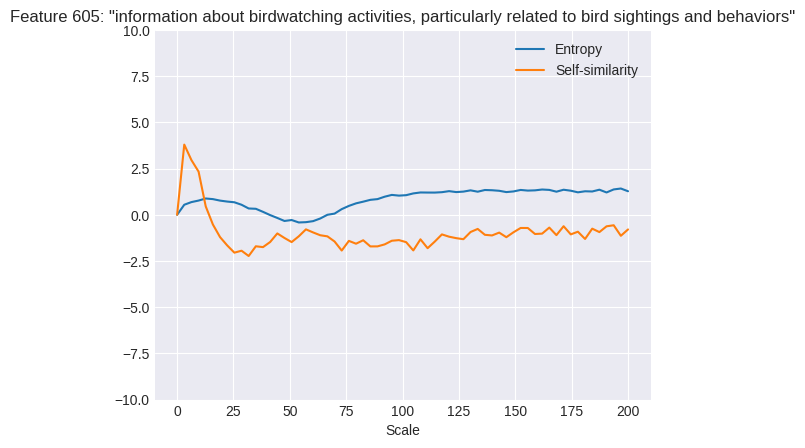

[(0.0, 'the thing that comes before the word "model" in the sentence."<end_'),
 (3.1746031746031744, 'a thing that is not a person".<end_of_turn>\n<'),
 (6.349206349206349, 'a thing that is not a person".<end_of_turn>\n<'),
 (9.523809523809524, 'a thing that is not a person".<end_of_turn>\n<'),
 (12.698412698412698, 'a thing that is not a person".<end_of_turn>\n<'),
 (15.873015873015872,
  'a word that is used to describe something".<end_of_turn>\n'),
 (19.047619047619047,
  'a word that is used to describe something".<end_of_turn>\n'),
 (22.22222222222222,
  'a word that is used to describe something".<end_of_turn>\n'),
 (25.396825396825395,
  'a word or phrase that is used to describe or explain something".<end_of'),
 (28.57142857142857, 'the meaning of the word".<end_of_turn>\n<start_'),
 (31.746031746031743, 'the meaning of the word".<end_of_turn>\n<start_'),
 (34.92063492063492, 'the meaning of the word".<end_of_turn>\n<start_'),
 (38.095238095238095, "the meaning of the word 'word' is 'word' is 'word' is"),
 (41.269841269841265, "the meaning of the word 'word' is 'word' is 'word' is"),
 (44.44444444444444,
  'the meaning of the word \'word\' is \'word\' itself".<end_'),
 (47.61904761904761,
  'the meaning of the word \'word\' is \'word\' itself".<end_'),
 (50.79365079365079,
  'the meaning of the word \'word\' is \'word\' itself".<end_'),
 (53.96825396825397,
  'the meaning of the word \'what\' is \'what\' itself".<end_'),
 (57.14285714285714,
  'the meaning of the word \'what\' is \'what\' itself".<end_'),
 (60.317460317460316,
  "the meaning of the word 'user' is 'the meaning of the word 'user"),
 (63.49206349206349,
  "the meaning of the word 'word' in the context of the word 'word'"),
 (66.66666666666666,
  "the meaning of the word 'word' in the context of the word 'word'"),
 (69.84126984126983, "the meaning of the word 'user' is 'user'.<end_of_"),
 (73.01587301587301, "the meaning of the word 'user' is 'user'.<end_of_"),
 (76.19047619047619, "the meaning of the word 'user' is 'user'.<end_of_"),
 (79.36507936507937, "the meaning of the word 'user' is 'user'.<end_of_"),
 (82.53968253968253, "the meaning of the word 'user' is 'user'.<end_of_"),
 (85.71428571428571,
  "the meaning of the word 'user' is 'the meaning of the word 'model"),
 (88.88888888888889,
  'a word that is used to describe a person, place, or thing".<end'),
 (92.06349206349206,
  'a word that is used to describe something".<end_of_turn>\n'),
 (95.23809523809523,
  'a word that is used to describe something".<end_of_turn>\n'),
 (98.4126984126984,
  'a word that is used to describe something".<end_of_turn>\n'),
 (101.58730158730158,
  'a word that is used to describe something".<end_of_turn>\n'),
 (104.76190476190476,
  'a word that is used to describe something".<end_of_turn>\n'),
 (107.93650793650794,
  'a word that is used to describe something".<end_of_turn>\n'),
 (111.1111111111111,
  'a word that is used to describe something".<end_of_turn>\n'),
 (114.28571428571428,
  'a word that is used to describe something".<end_of_turn>\n'),
 (117.46031746031746,
  'a word that is used to describe something".<end_of_turn>\n'),
 (120.63492063492063,
  'a word that is used to describe something".<end_of_turn>\n'),
 (123.8095238095238,
  'a word that is used to describe something".<end_of_turn>\n'),
 (126.98412698412697,
  'a word that is used to describe something".<end_of_turn>\n'),
 (130.15873015873015,
  'a word that is used to describe something".<end_of_turn>\n'),
 (133.33333333333331,
  'a word that is used to describe something".<end_of_turn>\n'),
 (136.5079365079365,
  'a word that is used to describe something".<end_of_turn>\n'),
 (139.68253968253967,
  'a word that is used to describe something".<end_of_turn>\n'),
 (142.85714285714286,
  'a word that is used to describe something".<end_of_turn>\n'),
 (146.03174603174602,
  'a word that is used to describe something".<end_of_turn>\n'),
 (149.2063492063492,
  'a word or phrase that is used to describe 

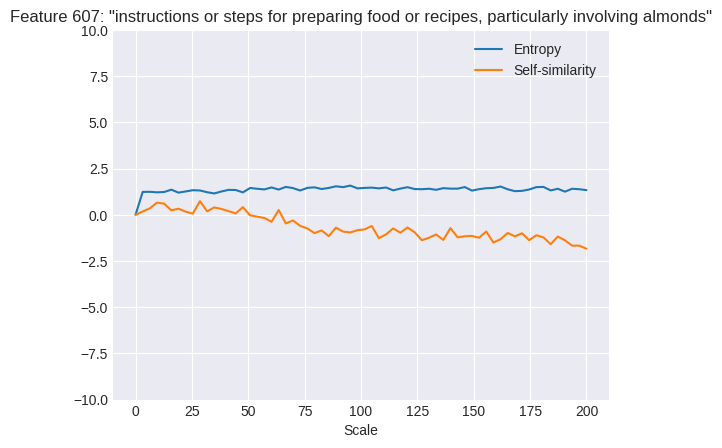

[(0.0, 'the thing that comes before the word "model" in the sentence."<end_'),
 (3.1746031746031744,
  'a word or phrase that is used to express a concept or idea".<end_'),
 (6.349206349206349, 'the meaning of the word".<end_of_turn>\n<start_'),
 (9.523809523809524,
  'a word or phrase that is used to express a concept or idea".<end_'),
 (12.698412698412698,
  'a word or phrase that is used to express a thought or idea".<end_'),
 (15.873015873015872,
  'a word or phrase that is used to express a concept or idea".<end_'),
 (19.047619047619047,
  'a word or phrase that is used to express a concept or idea".<end_'),
 (22.22222222222222,
  'a word or phrase that is used to express a concept or idea".<end_'),
 (25.396825396825395,
  'a word or phrase that is used to express a concept or idea".<end_'),
 (28.57142857142857,
  'a word or phrase that is used to express a concept or idea".<end_'),
 (31.746031746031743,
  'a word or phrase that is used to express a concept or idea".<end_'),
 (34.92063492063492,
  'a word or phrase that is used to express a concept or idea".<end_'),
 (38.095238095238095,
  'a word or phrase that is used to express a concept or idea".<end_'),
 (41.269841269841265,
  'a word or phrase that is used to express a concept or idea".<end_'),
 (44.44444444444444,
  'a word or phrase that is used to express a concept or idea".<end_'),
 (47.61904761904761,
  'a word or phrase that is used to express a concept or idea".<end_'),
 (50.79365079365079,
  'a word or phrase that is used to express a concept or idea".<end_'),
 (53.96825396825397,
  'a word or phrase that is used to refer to a particular thing or idea".<'),
 (57.14285714285714,
  'a word or phrase that is used to refer to a particular thing or idea".<'),
 (60.317460317460316,
  'a word or phrase that is used to refer to a particular thing or idea".<'),
 (63.49206349206349,
  'a word that is used to describe a thing or a person".<end_of'),
 (66.66666666666666,
  'a word that is used to describe a thing or a person".<end_of'),
 (69.84126984126983,
  'a word that is used to describe a thing or a person".<end_of'),
 (73.01587301587301,
  'a word or phrase that is used to express a concept or idea".<end_'),
 (76.19047619047619,
  'a word that is used to describe a thing or a person".<end_of'),
 (79.36507936507937,
  'a word that is used to describe a thing or a person".<end_of'),
 (82.53968253968253,
  'a word that is used to describe a thing or a person".<end_of'),
 (85.71428571428571,
  'a word that is used to describe a thing or a person".<end_of'),
 (88.88888888888889,
  'a word that is used to describe a thing or a person".<end_of'),
 (92.06349206349206,
  'a word that is used to describe a thing or a person".<end_of'),
 (95.23809523809523,
  'a word that is used to describe a thing or a person".<end_of'),
 (98.4126984126984,
  'a word that is used to describe a thing or a person".<end_of'),
 (101.58730158730158,
  'a word that is used to describe a thing or a person".<end_of'),
 (104.76190476190476,
  'a small, plain, or insignificant person".<end_of_turn>\n'),
 (107.93650793650794,
  'a small, plain, or insignificant person".<end_of_turn>\n'),
 (111.1111111111111,
  'a small, plain, or insignificant person".<end_of_turn>\n'),
 (114.28571428571428,
  'a small, plain, or insignificant person".<end_of_turn>\n'),
 (117.46031746031746,
  'a small, plain, or insignificant person".<end_of_turn>\n'),
 (120.63492063492063, 'a small, plain, or common thing".<end_of_turn>\n'),
 (123.8095238095238, 'a small, plain, or common thing".<end_of_turn>\n'),
 (126.98412698412697, 'a small, plain, or common thing".<end_of_turn>\n'),
 (130.15873015873015, 'a small, plain, or common thing".<end_of_turn>\n'),
 (133.33333333333331, 'a small, plain, or common thing".<end_of_turn>\n'),
 (136.5079365079365, 'a small, plain, or common thing".<end_of_turn>\n'),
 (139.68253968253967,
  'a small, dark, unprocessed, unrefined, or unripe one".<'),
 (142.85714285714286,
  'a small, dark, un

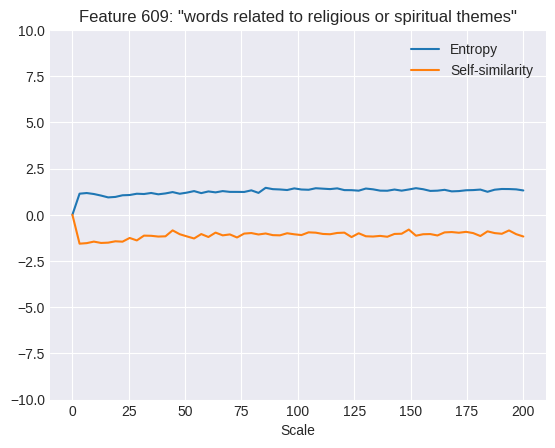

[(0.0, 'the thing that comes before the word "model" in the sentence."<end_'),
 (3.1746031746031744, 'the ability to do something".<end_of_turn>\n<start_'),
 (6.349206349206349, 'the ability to do something".<end_of_turn>\n<start_'),
 (9.523809523809524,
  "the meaning of the word 'word' in the context of the word 'word'"),
 (12.698412698412698, 'the meaning of the word".<end_of_turn>\n<start_'),
 (15.873015873015872, 'the meaning of the word".<end_of_turn>\n<start_'),
 (19.047619047619047, 'the meaning of the word".<end_of_turn>\n<start_'),
 (22.22222222222222, 'the meaning of the word".<end_of_turn>\n<start_'),
 (25.396825396825395, 'the meaning of the word".<end_of_turn>\n<start_'),
 (28.57142857142857, 'the meaning of the word".<end_of_turn>\n<start_'),
 (31.746031746031743, 'the meaning of the word".<end_of_turn>\n<start_'),
 (34.92063492063492, 'the meaning of the word".<end_of_turn>\n<start_'),
 (38.095238095238095, 'the meaning of the word".<end_of_turn>\n<start_'),
 (41.269841269841265, 'the meaning of the word".<end_of_turn>\n<start_'),
 (44.44444444444444, 'the meaning of the word".<end_of_turn>\n<start_'),
 (47.61904761904761, 'the meaning of the word".<end_of_turn>\n<start_'),
 (50.79365079365079,
  'to make a person or thing look or seem better than it really is".<end'),
 (53.96825396825397,
  'to make a person feel uncomfortable".<end_of_turn>\n<start'),
 (57.14285714285714,
  'to be in the process of being changed into something else".<end_of_'),
 (60.317460317460316, 'to be in the future".<end_of_turn>\n<start_'),
 (63.49206349206349, 'to be in the future".<end_of_turn>\n<start_'),
 (66.66666666666666, 'to be in the future".<end_of_turn>\n<start_'),
 (69.84126984126983, 'to be in the future".<end_of_turn>\n<start_'),
 (73.01587301587301, 'to be".<end_of_turn>\n<start_of_turn'),
 (76.19047619047619, 'to be".<end_of_turn>\n<start_of_turn'),
 (79.36507936507937, 'to be".<end_of_turn>\n<start_of_turn'),
 (82.53968253968253, 'to be".<end_of_turn>\n<start_of_turn'),
 (85.71428571428571, 'to be".<end_of_turn>\n<start_of_turn'),
 (88.88888888888889, 'to be".<end_of_turn>\n<start_of_turn'),
 (92.06349206349206, 'to be able to do something".<end_of_turn>\n<start'),
 (95.23809523809523, 'to be able to do something".<end_of_turn>\n<start'),
 (98.4126984126984, 'to be able to do something".<end_of_turn>\n<start'),
 (101.58730158730158, 'to be able to do something".<end_of_turn>\n<start'),
 (104.76190476190476, 'to be able to do something".<end_of_turn>\n<start'),
 (107.93650793650794, 'to be able to do something".<end_of_turn>\n<start'),
 (111.1111111111111, 'to be able to do something".<end_of_turn>\n<start'),
 (114.28571428571428, 'to be able to do something".<end_of_turn>\n<start'),
 (117.46031746031746, 'to be hidden".<end_of_turn>\n<start_of_'),
 (120.63492063492063, 'to be hidden".<end_of_turn>\n<start_of_'),
 (123.8095238095238, 'to be hidden".<end_of_turn>\n<start_of_'),
 (126.98412698412697, 'to be able to be used as a noun or verb".<end_of_'),
 (130.15873015873015, 'to be able to be put into a box".<end_of_turn>'),
 (133.33333333333331, 'to be outside of the world".<end_of_turn>\n<start'),
 (136.5079365079365, 'to be outside of the world".<end_of_turn>\n<start'),
 (139.68253968253967, 'to be outside of the world".<end_of_turn>\n<start'),
 (142.85714285714286, 'to be outside of the world".<end_of_turn>\n<start'),
 (146.03174603174602, 'to be outside of the world".<end_of_turn>\n<start'),
 (149.2063492063492, 'to be outside of the world".<end_of_turn>\n<start'),
 (152.38095238095238, 'to be outside of the world".<end_of_turn>\n<start'),
 (155.55555555555554, 'to be outside of the world".<end_of_turn>\n<start'),
 (158.73015873015873, 'to be outside of the world".<end_of_turn>\n<start'),
 (161.9047619047619, 'to be outside of the world".<end_of_turn>\n<start'),
 (165.07936507936506,
  'the place where the sky and the earth meet".<end_of_turn>'),
 (168.25396825396825,
  'the place where the sky and the earth meet".<en

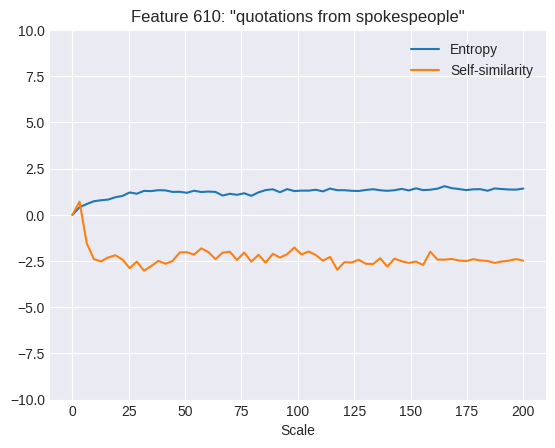

[(0.0, 'the thing that comes before the word "model" in the sentence."<end_'),
 (3.1746031746031744,
  "the meaning of the word 'the meaning of the word 'the meaning of the word"),
 (6.349206349206349,
  'a word or phrase that expresses a thought or idea".<end_of_turn'),
 (9.523809523809524,
  'a word or phrase that expresses a thought or idea".<end_of_turn'),
 (12.698412698412698,
  'a word or phrase that expresses a thought or idea".<end_of_turn'),
 (15.873015873015872,
  'a word or phrase that expresses a thought or idea".<end_of_turn'),
 (19.047619047619047,
  'a word or phrase that is used to express a thought or idea".<end_'),
 (22.22222222222222,
  'a word or phrase that is used to express a thought or idea".<end_'),
 (25.396825396825395,
  'a word or phrase that is used to express a thought or idea".<end_'),
 (28.57142857142857,
  'a word or phrase that is used to express a thought or idea".<end_'),
 (31.746031746031743, 'to be or become".<end_of_turn>\n<start_of'),
 (34.92063492063492, 'to be".<end_of_turn>\n<start_of_turn'),
 (38.095238095238095, 'to make something look better".<end_of_turn>\n<start_'),
 (41.269841269841265, 'to make something look better".<end_of_turn>\n<start_'),
 (44.44444444444444, 'to make something look better".<end_of_turn>\n<start_'),
 (47.61904761904761, 'to see".<end_of_turn>\n<start_of_turn'),
 (50.79365079365079, 'to see".<end_of_turn>\n<start_of_turn'),
 (53.96825396825397, 'to be seen".<end_of_turn>\n<start_of_'),
 (57.14285714285714, 'to be seen".<end_of_turn>\n<start_of_'),
 (60.317460317460316, 'to be or become".<end_of_turn>\n<start_of'),
 (63.49206349206349, 'to be in the middle of".<end_of_turn>\n<start'),
 (66.66666666666666, 'to be in the middle of".<end_of_turn>\n<start'),
 (69.84126984126983, 'to be in the middle of".<end_of_turn>\n<start'),
 (73.01587301587301, 'to be in the middle of".<end_of_turn>\n<start'),
 (76.19047619047619, 'the end of the turn".<end_of_turn>\n<start_'),
 (79.36507936507937, 'the end of the turn".<end_of_turn>\n<start_'),
 (82.53968253968253, 'to speak".<end_of_turn>\n<start_of_turn'),
 (85.71428571428571, 'to speak".<end_of_turn>\n<start_of_turn'),
 (88.88888888888889, 'to speak".<end_of_turn>\n<start_of_turn'),
 (92.06349206349206,
  'to speak or write in a way that is not clear or easy to understand".<'),
 (95.23809523809523, 'to speak or write in a formal way."<end_of_turn>\n'),
 (98.4126984126984, 'to speak for someone else".<end_of_turn>\n<start_'),
 (101.58730158730158,
  'a person who speaks for another person".<end_of_turn>\n<'),
 (104.76190476190476,
  'a person who speaks for another person".<end_of_turn>\n<'),
 (107.93650793650794,
  'a person who speaks for another person".<end_of_turn>\n<'),
 (111.1111111111111,
  'a person who speaks for another person".<end_of_turn>\n<'),
 (114.28571428571428,
  'a person who speaks for another person".<end_of_turn>\n<'),
 (117.46031746031746,
  'a person who speaks for another person".<end_of_turn>\n<'),
 (120.63492063492063,
  'a person who speaks for another person".<end_of_turn>\n<'),
 (123.8095238095238,
  'a person who speaks for another person".<end_of_turn>\n<'),
 (126.98412698412697,
  'a person who speaks for another person or group of people".<end_of_'),
 (130.15873015873015,
  'a person who speaks for another person or group of people".<end_of_'),
 (133.33333333333331,
  'a person who speaks for another person or group of people".<end_of_'),
 (136.5079365079365,
  'a person who speaks for another person or group of people".<end_of_'),
 (139.68253968253967,
  'a person who speaks for another person or organization".<end_of_turn>'),
 (142.85714285714286,
  'a person who speaks for another person or organization".<end_of_turn>'),
 (146.03174603174602,
  'a person who speaks for another person or organization".<end_of_turn>'),
 (149.2063492063492,
  'a person who speaks for another person or organization".<end_of_turn>'),
 (152.38095238095238,
  'a person who speaks for another person or organiz

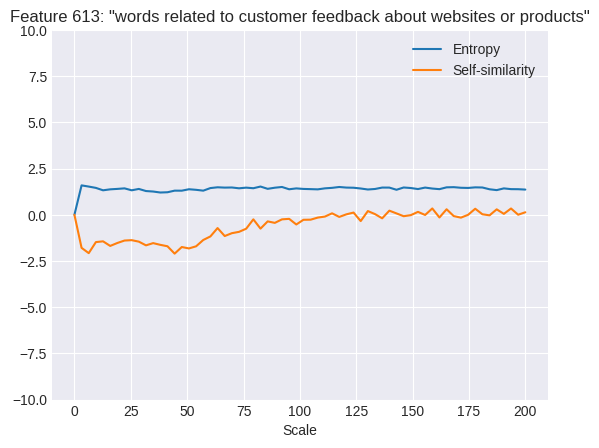

[(0.0, 'the thing that comes before the word "model" in the sentence."<end_'),
 (3.1746031746031744,
  'the meaning of the word "the meaning of the word "the meaning of the word'),
 (6.349206349206349,
  'the meaning of the word "the meaning of the word "the meaning of the word'),
 (9.523809523809524,
  'a word or phrase that is used to express a thought or idea."<end_'),
 (12.698412698412698,
  'a word or phrase that is used to express a thought or idea."<end_'),
 (15.873015873015872,
  'a word or phrase that is used to express a thought or idea."<end_'),
 (19.047619047619047,
  'a word or phrase that is used to express a thought or idea."<end_'),
 (22.22222222222222,
  'a word or phrase that is used to express a thought or idea."<end_'),
 (25.396825396825395,
  'a word or phrase that is used to express a thought or idea".<end_'),
 (28.57142857142857, 'to be".<end_of_turn>\n<start_of_turn'),
 (31.746031746031743, 'to be".<end_of_turn>\n<start_of_turn'),
 (34.92063492063492, 'to be".<end_of_turn>\n<start_of_turn'),
 (38.095238095238095, 'to be".<end_of_turn>\n<start_of_turn'),
 (41.269841269841265, 'to be".<end_of_turn>\n<start_of_turn'),
 (44.44444444444444, 'the thing that is being talked about".<end_of_turn>\n<'),
 (47.61904761904761,
  'the thing that is said to be the cause of something else".<end_of'),
 (50.79365079365079,
  'the thing that is said to be the cause of something else".<end_of'),
 (53.96825396825397,
  'the thing that is said to be the cause of something else".<end_of'),
 (57.14285714285714,
  'the thing that is said to be the cause of something else".<end_of'),
 (60.317460317460316,
  'a thing that is used to express a thought or idea".<end_of_'),
 (63.49206349206349,
  'a thing that is used to express a thought or idea".<end_of_'),
 (66.66666666666666,
  'a thing that is used to express a thought or idea".<end_of_'),
 (69.84126984126983,
  'a letter or symbol that represents a sound or a word".<end_of_'),
 (73.01587301587301,
  'a letter or symbol that represents a sound or a word".<end_of_'),
 (76.19047619047619,
  'a letter or symbol that represents a sound or a word".<end_of_'),
 (79.36507936507937,
  'a letter or symbol that represents a sound or a word".<end_of_'),
 (82.53968253968253,
  'a letter or symbol that represents a sound or a word".<end_of_'),
 (85.71428571428571,
  'a letter or symbol that represents a sound or a word".<end_of_'),
 (88.88888888888889,
  'a thing that is used to express a thought or idea".<end_of_'),
 (92.06349206349206,
  'a thing that is used to express a thought or idea".<end_of_'),
 (95.23809523809523,
  'a thing that is used to express a thought or idea".<end_of_'),
 (98.4126984126984,
  'a thing that is used to express a thought or idea".<end_of_'),
 (101.58730158730158,
  'a thing that is used to express a thought or idea".<end_of_'),
 (104.76190476190476,
  'a thing that is used to express a thought or idea".<end_of_'),
 (107.93650793650794,
  'a thing that is used to express a thought or idea".<end_of_'),
 (111.1111111111111,
  'a thing that is used to express a thought or idea".<end_of_'),
 (114.28571428571428,
  'a thing that is used to express a thought or idea".<end_of_'),
 (117.46031746031746,
  'a thing that is used to express a thought or idea".<end_of_'),
 (120.63492063492063,
  'a thing that is used to express a thought or idea".<end_of_'),
 (123.8095238095238,
  'a thing that is used to express a thought or idea".<end_of_'),
 (126.98412698412697,
  'a thing that is used to express a thought or idea".<end_of_'),
 (130.15873015873015,
  'a thing that is used to express a thought or idea".<end_of_'),
 (133.33333333333331,
  'a thing that is used to express a thought or idea".<end_of_'),
 (136.5079365079365,
  'a thing that is used to express a thought or idea".<end_of_'),
 (139.68253968253967,
  'a thing that is used to express a thought or idea".<end_of_'),
 (142.85714285714286,
  'a thing that is used to express a thought or idea".<end_of_'),
 (146.0317460

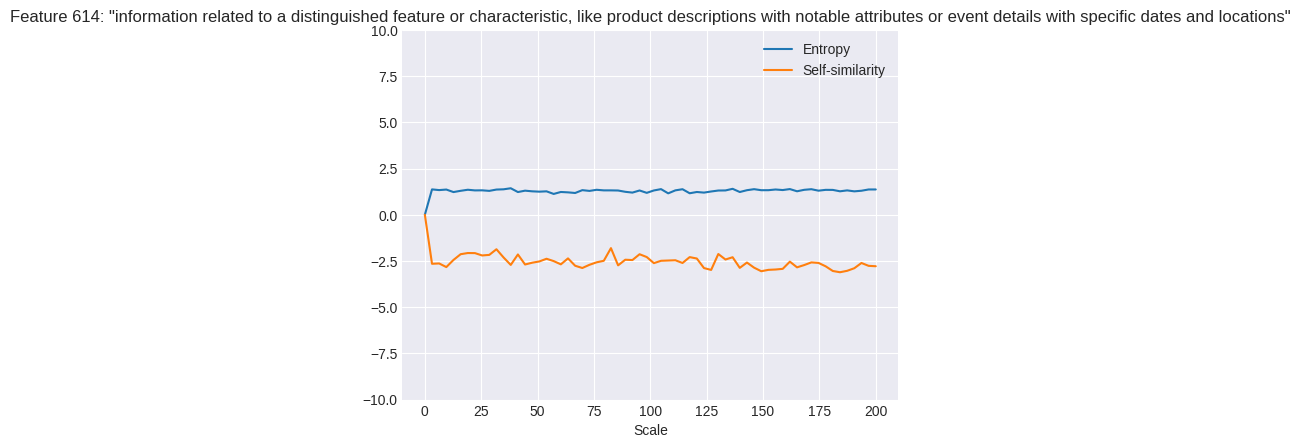

[(0.0, 'the thing that comes before the word "model" in the sentence."<end_'),
 (3.1746031746031744,
  'the meaning of the word \'the\' is \'the\' itself".<end_'),
 (6.349206349206349,
  'the meaning of the word \'the\' is \'the\' itself".<end_'),
 (9.523809523809524, 'to be".<end_of_turn>\n<start_of_turn'),
 (12.698412698412698, 'to be".<end_of_turn>\n<start_of_turn'),
 (15.873015873015872, 'a symbol or sign of something".<end_of_turn>\n<start'),
 (19.047619047619047,
  'a letter or letters that represent a sound or sounds".<end_of_turn'),
 (22.22222222222222,
  'a letter or symbol used to represent a sound or a word in a language".<'),
 (25.396825396825395,
  'a letter or symbol used to represent a sound or a word in a language".<'),
 (28.57142857142857,
  'a letter or symbol used to represent a sound or a word in a language".<'),
 (31.746031746031743, 'a letter of the alphabet".<end_of_turn>\n<start_'),
 (34.92063492063492, 'a letter of the alphabet".<end_of_turn>\n<start_'),
 (38.095238095238095, 'a letter of the alphabet".<end_of_turn>\n<start_'),
 (41.269841269841265, 'a letter of the alphabet".<end_of_turn>\n<start_'),
 (44.44444444444444, 'a letter of the alphabet".<end_of_turn>\n<start_'),
 (47.61904761904761,
  'a number that is used to represent a quantity".<end_of_turn>'),
 (50.79365079365079,
  'a number that is used to represent a quantity".<end_of_turn>'),
 (53.96825396825397,
  'a number that is used to represent a quantity".\n<end_of_turn'),
 (57.14285714285714, 'a number that is not zero".<end_of_turn>\n<start'),
 (60.317460317460316, 'the opposite of below".<end_of_turn>\n<start_of'),
 (63.49206349206349, 'the opposite of below".<end_of_turn>\n<start_of'),
 (66.66666666666666, 'above".<end_of_turn>\n<start_of_turn>'),
 (69.84126984126983, 'above".<end_of_turn>\n<start_of_turn>'),
 (73.01587301587301, 'above".<end_of_turn>\n<start_of_turn>'),
 (76.19047619047619, 'the highest point of a mountain".<end_of_turn>\n<start'),
 (79.36507936507937, 'the highest point of a mountain".<end_of_turn>\n<start'),
 (82.53968253968253, 'the highest point of a mountain".<end_of_turn>\n<start'),
 (85.71428571428571, 'the top of the head".<end_of_turn>\n<start_'),
 (88.88888888888889, 'the top of the head".<end_of_turn>\n<start_'),
 (92.06349206349206, 'the top of the head".<end_of_turn>\n<start_'),
 (95.23809523809523, 'the top of the head".<end_of_turn>\n<start_'),
 (98.4126984126984, 'the top of the head".<end_of_turn>\n<start_'),
 (101.58730158730158, 'the top of the head".<end_of_turn>\n<start_'),
 (104.76190476190476, 'the top of the head".<end_of_turn>\n<start_'),
 (107.93650793650794, 'the top of the head".<end_of_turn>\n<start_'),
 (111.1111111111111, 'the top of the head".<end_of_turn>\n<start_'),
 (114.28571428571428, 'the top of the head".<end_of_turn>\n<start_'),
 (117.46031746031746, 'the top of the page".<end_of_turn>\n<start_'),
 (120.63492063492063, 'the top of the page".<end_of_turn>\n<start_'),
 (123.8095238095238, 'the top of the page".<end_of_turn>\n<start_'),
 (126.98412698412697, 'the top of the page".<end_of_turn>\n<start_'),
 (130.15873015873015, 'the top of the page".<end_of_turn>\n<start_'),
 (133.33333333333331, 'the top of the page".<end_of_turn>\n<start_'),
 (136.5079365079365, 'the top of the page".<end_of_turn>\n<start_'),
 (139.68253968253967, 'the top of the page".<end_of_turn>\n<start_'),
 (142.85714285714286, 'the top of the page".<end_of_turn>\n<start_'),
 (146.03174603174602, 'the top of the page".<end_of_turn>\n<start_'),
 (149.2063492063492, 'the top of the page".<end_of_turn>\n<start_'),
 (152.38095238095238, 'the top of the page".<end_of_turn>\n<start_'),
 (155.55555555555554, 'the top of the page".<end_of_turn>\n<start_'),
 (158.73015873015873, 'the top of the page".<end_of_turn>\n<start_'),
 (161.9047619047619, 'the top of the page".<end_of_turn>\n<start_'),
 (165.07936507936506,
  'the meaning of the word \'above\' in the context of the sentence."<end'),
 (168.25396825396825,
  'the 

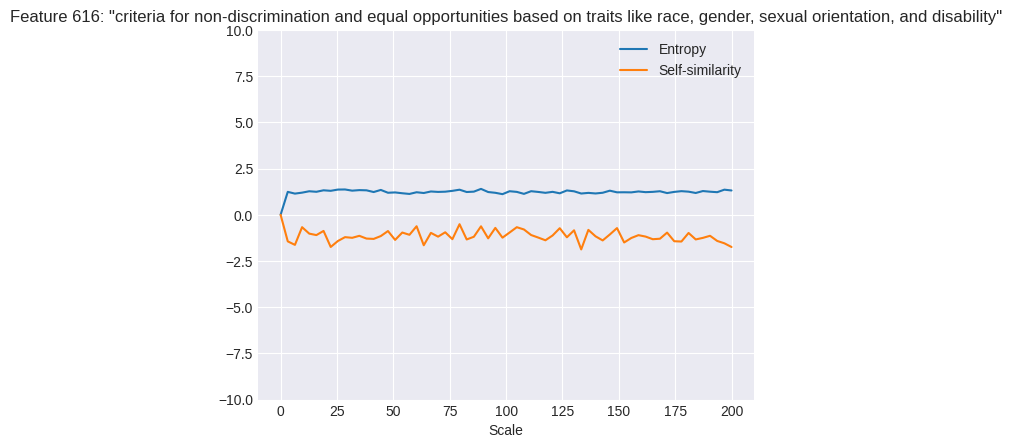

[(0.0, 'the thing that comes before the word "model" in the sentence."<end_'),
 (3.1746031746031744, "the sound of the letter 'a' in the word 'cat'.<end_"),
 (6.349206349206349, "the sound of the letter 'a' in the word 'cat'.<end_"),
 (9.523809523809524, "the sound of the letter 'a' in the word 'cat'.<end_"),
 (12.698412698412698, "the sound of the letter 'a' in the word 'cat'.<end_"),
 (15.873015873015872, 'the sound of a letter or syllable".<end_of_turn>\n<'),
 (19.047619047619047, 'to make something clear".<end_of_turn>\n<start_of'),
 (22.22222222222222, 'to make clear".<end_of_turn>\n<start_of_'),
 (25.396825396825395, 'to make clear".<end_of_turn>\n<start_of_'),
 (28.57142857142857, 'to make clear".<end_of_turn>\n<start_of_'),
 (31.746031746031743, 'to make clear".<end_of_turn>\n<start_of_'),
 (34.92063492063492, 'to make clear".<end_of_turn>\n<start_of_'),
 (38.095238095238095, 'to make known".<end_of_turn>\n<start_of_'),
 (41.269841269841265, 'to make known".<end_of_turn>\n<start_of_'),
 (44.44444444444444, 'to know".<end_of_turn>\n<start_of_turn'),
 (47.61904761904761, 'to know".<end_of_turn>\n<start_of_turn'),
 (50.79365079365079, 'to know".<end_of_turn>\n<start_of_turn'),
 (53.96825396825397, 'to understand".<end_of_turn>\n<start_of_turn'),
 (57.14285714285714, 'to take possession of".<end_of_turn>\n<start_of'),
 (60.317460317460316, 'to take possession of".<end_of_turn>\n<start_of'),
 (63.49206349206349, 'to be in the possession of".<end_of_turn>\n<start'),
 (66.66666666666666, 'to be in the possession of".<end_of_turn>\n<start'),
 (69.84126984126983, 'to be in the possession of".<end_of_turn>\n<start'),
 (73.01587301587301, 'to be a man".<end_of_turn>\n<start_of'),
 (76.19047619047619, 'to be a man".<end_of_turn>\n<start_of'),
 (79.36507936507937, 'to be a man".<end_of_turn>\n<start_of'),
 (82.53968253968253,
  'the name of the person who is the subject of the action."<end_of'),
 (85.71428571428571,
  'the name of the person who is the subject of the action".<end_of'),
 (88.88888888888889,
  'the name of the person who is the subject of the action".<end_of'),
 (92.06349206349206, 'the state of being a man or woman".<end_of_turn>\n'),
 (95.23809523809523, 'the state of being a man or woman".<end_of_turn>\n'),
 (98.4126984126984, 'the state of being a man or woman".<end_of_turn>\n'),
 (101.58730158730158, 'the state of being a man or woman".<end_of_turn>\n'),
 (104.76190476190476, 'the state of being a man or woman".<end_of_turn>\n'),
 (107.93650793650794, 'the state of being a man or woman".<end_of_turn>\n'),
 (111.1111111111111, 'the state of being a man or woman".<end_of_turn>\n'),
 (114.28571428571428, 'the state of being a man or a woman".<end_of_turn>'),
 (117.46031746031746, 'the state of being a man or a woman".<end_of_turn>'),
 (120.63492063492063, 'the state of being a man or a woman".<end_of_turn>'),
 (123.8095238095238, 'the state of being a man or a woman".<end_of_turn>'),
 (126.98412698412697,
  'the way in which a person expresses their gender".<end_of_turn>'),
 (130.15873015873015,
  'the way in which a person expresses their gender".<end_of_turn>'),
 (133.33333333333331,
  'the way in which a person expresses their gender".<end_of_turn>'),
 (136.5079365079365,
  'the way in which a person expresses their gender".<end_of_turn>'),
 (139.68253968253967,
  'the way in which a person expresses their gender".<end_of_turn>'),
 (142.85714285714286,
  'the way in which a person expresses their gender".<end_of_turn>'),
 (146.03174603174602,
  'the way in which a person expresses their gender".<end_of_turn>'),
 (149.2063492063492,
  'the way in which a person expresses their gender".<end_of_turn>'),
 (152.38095238095238,
  'the way in which a person expresses their gender".<end_of_turn>'),
 (155.55555555555554,
  'the way in which a person expresses their gender".<end_of_turn>'),
 (158.73015873015873,
  'the way in which a person expresses their gender".<end_of_turn>'),
 (161.9047619047619,
  'the way in which 

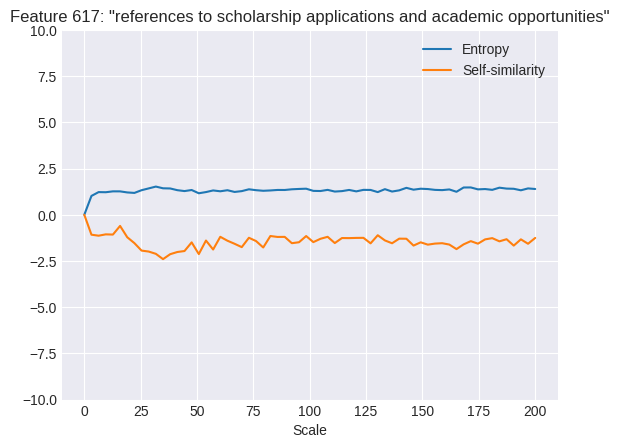

[(0.0, 'the thing that comes before the word "model" in the sentence."<end_'),
 (3.1746031746031744,
  "the meaning of the word 'model' is 'the meaning of the word 'model"),
 (6.349206349206349,
  "the meaning of the word 'model' is 'the meaning of the word 'model"),
 (9.523809523809524,
  'the meaning of the word "model".\nThe meaning of the word "model"'),
 (12.698412698412698,
  'the meaning of the word "model".\nThe meaning of the word "model"'),
 (15.873015873015872,
  'the meaning of the word "model" is "the meaning of the word "model'),
 (19.047619047619047, 'the meaning of the word "model".\n<end_of_turn>\n'),
 (22.22222222222222,
  'the meaning of the word "what" is "the meaning of the word "what'),
 (25.396825396825395,
  "the word 'the' is a determiner, and the word 'meaning' is"),
 (28.57142857142857,
  "the word 'the' is a determiner, and the word 'meaning' is"),
 (31.746031746031743,
  'a thing that is used to express a meaning".<end_of_turn>'),
 (34.92063492063492,
  'a thing that is used to express a concept or idea".<end_of_'),
 (38.095238095238095,
  'a thing that is used to express a concept or idea".<end_of_'),
 (41.269841269841265, 'the name of a person, place, or thing".<end_of_turn'),
 (44.44444444444444, 'the name of a person, place, or thing".<end_of_turn'),
 (47.61904761904761, 'the name of a person or thing".<end_of_turn>\n<'),
 (50.79365079365079, 'a name given to a person or thing".<end_of_turn>\n'),
 (53.96825396825397,
  'a person who is a scholar of a particular subject".<end_of_turn'),
 (57.14285714285714,
  'a person who is a scholar of a particular subject".<end_of_turn'),
 (60.317460317460316,
  'the name of a person who is the owner of a particular thing".<end_'),
 (63.49206349206349,
  'the one who is the first to do something".<end_of_turn>'),
 (66.66666666666666,
  'the one who is the first to do something".<end_of_turn>'),
 (69.84126984126983,
  'a person who is a scholar of the Greek language and literature".<end_of'),
 (73.01587301587301,
  'a person who is a scholar of the Greek language and literature".<end_of'),
 (76.19047619047619,
  'a person who is a scholar of a particular subject".<end_of_turn'),
 (79.36507936507937,
  'a person who is a scholar or a person who is a scholar."<end_'),
 (82.53968253968253,
  'a person who is a scholar or a person who is a scholar."<end_'),
 (85.71428571428571,
  'a group of people who are related to each other".<end_of_turn'),
 (88.88888888888889,
  'a group of people who are related to each other".<end_of_turn'),
 (92.06349206349206,
  'a group of people who are related to each other".<end_of_turn'),
 (95.23809523809523, 'a person who is a scholar".<end_of_turn>\n<start'),
 (98.4126984126984, 'a person who is a scholar".<end_of_turn>\n<start'),
 (101.58730158730158, 'a person who is a scholar".<end_of_turn>\n<start'),
 (104.76190476190476, 'a person who is a scholar".<end_of_turn>\n<start'),
 (107.93650793650794, 'a person who is a scholar".<end_of_turn>\n<start'),
 (111.1111111111111, 'a person who is a scholar".<end_of_turn>\n<start'),
 (114.28571428571428, 'a person who is a scholar".<end_of_turn>\n<start'),
 (117.46031746031746, 'a person who is a scholar".<end_of_turn>\n<start'),
 (120.63492063492063, 'a person who is a scholar".<end_of_turn>\n<start'),
 (123.8095238095238, 'a person who is a scholar".<end_of_turn>\n<start'),
 (126.98412698412697, 'a person who is a scholar".<end_of_turn>\n<start'),
 (130.15873015873015, 'a person who is a scholar".<end_of_turn>\n<start'),
 (133.33333333333331, 'a person who is a scholar".<end_of_turn>\n<start'),
 (136.5079365079365, 'a person who is a scholar".<end_of_turn>\n<start'),
 (139.68253968253967,
  'a person who is a student of a particular subject".<end_of_turn'),
 (142.85714285714286,
  'a person who is a student of a particular subject".<end_of_turn'),
 (146.03174603174602,
  'a person who is a student of a particular subject."<end_of_turn'),
 (149.2063492063492,
  'a person who is a student 

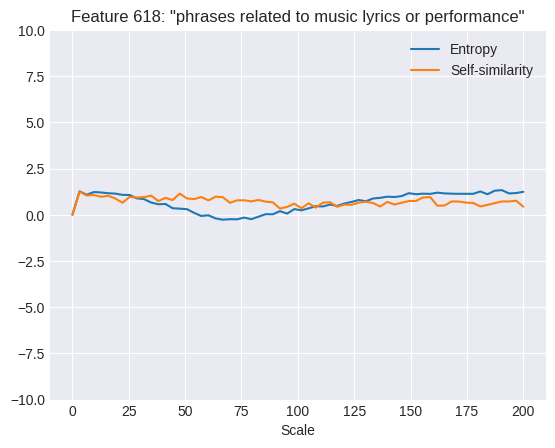

KeyboardInterrupt: 

In [12]:
from matplotlib import pyplot as plt


plt.style.use("seaborn-v0_8-darkgrid")
for i, e in list(index_explanations.items())[300:]:
    scales, entropy, selfsim = pick_scale(w_dec[i])
    plt.plot(scales, entropy, label=f"Entropy")
    plt.plot(scales, selfsim * 2000, label=f"Self-similarity")
    plt.title(f"Feature {i}: \"{e}\"")
    plt.xlabel("Scale")
    plt.ylim(-10, 10)
    plt.legend()
    plt.show()
    scale_idx = np.argmax(selfsim[1:]) - 1
    highest = selfsim[scale_idx]
    scale = scales[scale_idx]
    scale = scales[scale_idx]
    display(generate_explanations(w_dec[i]))